In [1]:
%load_ext autoreload
%autoreload

Load the LLM

In [2]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_community.llms.mlx_pipeline import MLXPipeline
from langchain_community.chat_models.mlx import ChatMLX
from langchain.callbacks.tracers import ConsoleCallbackHandler
from langchain.globals import set_verbose
from langchain.globals import set_debug

#set_debug(True)
#set_verbose(True)

print('Loading model...')
# Load model from huggingface, using the MLX framework to take advantage of Apple Silicon
llm = MLXPipeline.from_model_id(
    #"mlx-community/Meta-Llama-3.1-8B-Instruct-8bit",
    #"mlx-community/Meta-Llama-3.1-8B-Instruct-bf16",
    "mlx-community/Qwen2.5-32B-Instruct-4bit", # Let's try using a larger model, see if that improves results
    #"mlx-community/Llama-3.2-3B-Instruct-8bit",
    pipeline_kwargs={"max_tokens": 2048, "temp": 0.2, "repetition_penalty":1.2},
)

# Setup verbose mode: https://stackoverflow.com/a/77629872/10914628
model = ChatMLX(llm=llm, verbose=True)#.with_config({'callbacks': [ConsoleCallbackHandler()]})
print('Model loaded.')


Loading model...


/Users/frieder/Documents/GitHub/procedural-stories/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 12 files: 100%|██████████| 12/12 [00:00<00:00, 32619.34it/s]


Model loaded.


Load the ontology

In [3]:
from owlready2 import *

onto = get_ontology('file://story_ontology3.rdf').load()

In [4]:
# Verify that there are no instances in the ontology (start with a clean ontology containg only the T-Box)

with onto:
    instances = list(Thing.instances())
    
    if len(instances) > 0:
        for thing in instances:
            print(thing)
        raise ValueError('Ontology already contains individuals')
    
    print('OK')

OK


In [5]:
from urllib.parse import quote, unquote

def encode_entity_name(name: str) -> str:
    return quote(name.lower())

def decode_entity_name(encoded_name: str) -> str:
    return unquote(encoded_name)

In [6]:
from Levenshtein import distance

def find_levenshtein_match(string: str, entity_list: list, threshold: int = 5):
    """Find a match amongst a list of entities from the ontology, in case the LLM made slight typos !"""
    minimum = threshold
    closest_entity = None
    for entity in entity_list:
        dist = distance(string, entity.hasName)
        if dist < minimum:
            minimum = dist
            closest_entity = entity
    return closest_entity

Define the setting of the story

In [7]:
#setting = "Normandie viking du 9e siècle"
setting = "post-apocalypse zombie mondiale, 1 an après le début de l'épidémie"
language = "french"

# 1. Generate the outline of the story world

In [8]:
OUTLINE_TEXT_PROMPT = """
You are the master writer tasked with creating a vibrant world specifically made to host a text adventure game for a player.
Write a few paragraphs describing the world of the story following the given narrative setting:

{{ setting }}

Your text should be quite short, concise and descriptive.
Your staff will use this text as the story world bible, they will write the characters, locations and specific events.
You should direct them as precisely as possible to create as coherent and unified world for the player to explore.
Define the player's role in this world, as well as a high level, open but concrete goal, conflict and motivations.
Write your output in {{ language }}.
"""

In [9]:

prompt = PromptTemplate(
    template=OUTLINE_TEXT_PROMPT,
    template_format='jinja2'
)

chain = prompt | model

outline_text = chain.invoke({'setting': setting, 'language': language}).content

print(outline_text)

Dans un monde post-apocalyptique envahi par les zombies, la Terre telle que nous la connaissions n'existe plus depuis maintenant un an. Les grandes villes sont des ruines fumantes où seuls les morts-vivants errent sans cesse à travers ce qui reste d'infrastructures délabrées et de bâtiments effondrés. La nature commence doucement mais sûrement son processus de reconquête sur ces terres abandonnées.

Les survivants ont formé des communautés isolées pour résister aux hordes incessantes de créatures infectées. Ces dernières cherchent constamment du sang frais dans une quête éternelle de chair vivante. L'eau potable est rare, les ressources alimentaires encore moins abondantes ; chaque jour devient alors une lutte pour la survie face au danger omniprésent.

Le joueur incarne un membre de cette communauté désespérée, chargé d'une mission cruciale : trouver une source stable de nourriture ou d’eau propre afin de permettre à sa tribu de tenir quelques jours supplémentaires contre cet environn

# 2. Generate locations

In [10]:
LOCATIONS_GENERATION_PROMPT = """
You are the master world writer for an interactive fiction.
On the basis of the given narrative context, create a list of locations in the world, which will be scenes in the IF.
Define at least 4 to 5 main locations, as well as intermediate locations if pertinent.
Your staff will use your work to refine each location, so you should make sure each location incoporates sufficient information for them to do so !
You must take utmost care in creating a logical topology with no islands and coherent connections.
Always refer to other locations using their "name" property in the links ! **You should define all locations mentioned in the links.**

Output your work in the following JSON format:
```json
    "Locations": [
        {
            "name": "Suchandsuch Town",
            "importance": "Either 'major' or 'minor', this annotation will influence how your staff will detail the"
            "description": "Description en quelques phrases du lieu, incorporant son atmosphère, son importance dans l'histoire et tout élément notable qui pourrait influencer les événements ou les personnages.",
            "links": ["Chateau thing"]
        },
        {
            "name": "Chateau thing",
            "importance": "Either 'major' or 'minor', this annotation will influence how your staff will detail the"
            "description": "Description en quelques phrases du lieu, incorporant son atmosphère, son importance dans l'histoire et tout élément notable qui pourrait influencer les événements ou les personnages.",
            "links": ["Suchandsuch Town", "Nom d'un autre lieu"]
        },
        ...
    ],
```

Narrative context:
{{ context }}

Your output JSON values should always be in {{ language }}
"""

In [11]:
prompt = PromptTemplate(
    template=LOCATIONS_GENERATION_PROMPT,
    template_format='jinja2'
)

parser = JsonOutputParser()

chain = prompt | model | parser

locations_output = chain.invoke({
    'context': outline_text,
    'language': language
})

location_outlines = locations_output['Locations']

location_outlines

[{'name': 'Village des Survivants',
  'importance': 'major',
  'description': "Ce village représente la dernière bastion de civilisation humaine dans cette région ravagée par les zombies. Protégé derrière des murs solides et surveillé nuit et jour, il sert de refuge sûr pour ses habitants. C'est ici que notre héros partira pour accomplir sa mission critique.",
  'links': ['Forêt Abandonnée', 'Ruine Urbaine']},
 {'name': 'Forêt Abandonnée',
  'importance': 'minor',
  'description': "Une vaste étendue boisée qui était autrefois peuplée de faune variée avant l'épidémie zombie. Maintenant, elle offre un couvert idéal pour les survivants tentant de collecter des ressources essentielles comme l'eau fraîche et les fruits sauvages. Attention, certains secteurs peuvent contenir des groupes errants de zombies attirés par leur instinct animal.",
  'links': ['Village des Survivants', 'Lac Pollué', 'Mine Délaissée']},
 {'name': 'Ruine Urbaine',
  'importance': 'major',
  'description': 'Un ancien q

Let's try to directly append new information to the KG as we go

In [12]:
# Add the generated locations to the KG
with onto:
    # Create each location entity in the graph
    for loc in location_outlines:
        uri = encode_entity_name(loc.get('name'))
        location = onto.Location(uri)
        
        location.label = loc.get('name')
        location.hasName = loc.get('name')
        location.hasDescription = loc.get('description')

        print(f'Created Location entity {loc.get('name')}')
    
    # Connect each location based on their "links" property
    for loc in location_outlines:
        location = find_levenshtein_match(loc.get('name'), onto.Location.instances())
        links = loc.get('links')

        #location.isLinkedToLocation = []
        
        for other_location_name in links:
            other_uri = encode_entity_name(other_location_name)
            
            # link Location entities using the isLinkedToLocation property (symmetrical)
            other_location = find_levenshtein_match(other_location_name, onto.Location.instances())
            
            # Check if the other location exists in the ontology
            if other_location is not None:
                # Link the locations using the isLinkedToLocation property
                location.isLinkedToLocation.append(other_location)
            else:
                # Print a warning or handle the missing location case as needed
                print(f"Warning: Location '{other_location_name}' with URI '{other_uri}' not found in ontology.")


Created Location entity Village des Survivants
Created Location entity Forêt Abandonnée
Created Location entity Ruine Urbaine
Created Location entity Lac Pollué
Created Location entity Mine Délaissée


Verify that the connections were made successfully

In [13]:
with onto:
    for location in onto.Location.instances():
        print(f'{location.hasName} is connected to: {[l.hasName for l in location.INDIRECT_isLinkedToLocation]}')

Village des Survivants is connected to: ['Forêt Abandonnée', 'Ruine Urbaine']
Forêt Abandonnée is connected to: ['Lac Pollué', 'Village des Survivants', 'Mine Délaissée']
Ruine Urbaine is connected to: ['Village des Survivants']
Lac Pollué is connected to: ['Forêt Abandonnée']
Mine Délaissée is connected to: ['Forêt Abandonnée']


In [14]:
with onto:
    for location in onto.Location.instances():
        print(f'{location.hasName}: {location.hasDescription}')

Village des Survivants: Ce village représente la dernière bastion de civilisation humaine dans cette région ravagée par les zombies. Protégé derrière des murs solides et surveillé nuit et jour, il sert de refuge sûr pour ses habitants. C'est ici que notre héros partira pour accomplir sa mission critique.
Forêt Abandonnée: Une vaste étendue boisée qui était autrefois peuplée de faune variée avant l'épidémie zombie. Maintenant, elle offre un couvert idéal pour les survivants tentant de collecter des ressources essentielles comme l'eau fraîche et les fruits sauvages. Attention, certains secteurs peuvent contenir des groupes errants de zombies attirés par leur instinct animal.
Ruine Urbaine: Un ancien quartier urbain transformé en champ de bataille permanent contre les zombies. Des immeubles écroulés et des rues jonchées de cadavres offrent peu de protection mais beaucoup de risques. Pourtant, si on peut y pénétrer discrètement, cela pourrait fournir des provisions précieuses.
Lac Pollué: 

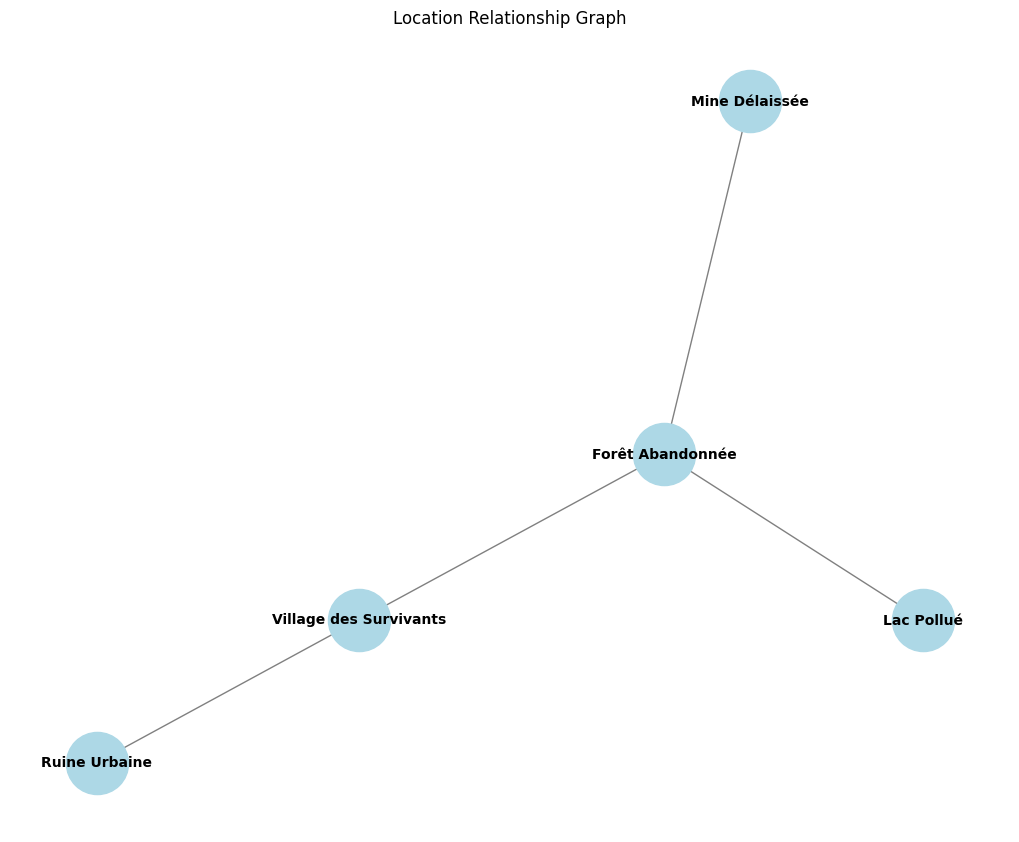

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

def display_location_relationships(locations: onto.Location):
    # Create a graph
    G = nx.Graph()

    # Add nodes and edges
    for location in locations:
        G.add_node(location.hasName)  # Add each location as a node
        for related_location in location.INDIRECT_isLinkedToLocation:
            # Create edges for relationships
            G.add_edge(location.hasName, related_location.hasName)

    # Draw the graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)  # Positioning of the graph

    # Draw nodes, edges, and labels
    nx.draw(G, pos,
            with_labels=True,
            node_color='lightblue',
            node_size=2000,
            font_size=10,
            font_weight='bold',
            edge_color='gray')
    plt.title('Location Relationship Graph')
    plt.show()

with onto:
    display_location_relationships(onto.Location.instances())

Structure works, it's a hub structure with linear branches. This is good enough ! The topology makes sense regarding the relationships of locations.
Extra points for the water structure

## Generate a structured outline of the story from the outline text and generated locations

In [16]:
STORY_OUTLINE_PROMPT = """
# Instructions pour la génération
Vous êtes le scénariste de l'histoire pour une aventure textuelle générative.
Sur la base du contexte narratif et des lieux qui composent le monde ci-dessous, générez les grandes lignes d'une histoire possible en tenant créant les éléments suivants :

    Joueur : Établir la position et le rôle du joueur dans l'histoire, en précisant leur identité, leurs motivations et leur lien avec les personnages principaux. Décrire le point de départ du joueur et son rôle dans le récit global.
    Personnages: Etablir une liste d'au moins **3 à 5** personnages principaux de l'histoire, sans rentrer dans trop de détails mais en évoquant leur fonction narrative et leurs relations (entre eux et avec le joueur). Veille à établir au moins un antagoniste principal.
    Objectif : Définir l'objectif global du joueur, en précisant le problème principal à résoudre ou l'enjeu narratif qui motive l'action.
    Événements : Décrire au moins 1 à 3 événements clés qui alimentent l'histoire et doivent être déclenchés par l'action du joueur.
    Objets : Générer uniquement les éléments essentiels nécessaires pour compléter l'histoire (objets de quête) si c'est mentionné dans le contexte narratif, en incluant : Un nom et une description de chaque objet, avec sa fonction dans le récit. Indiquer le lieu où se trouve chaque objet, en s'assurant qu'il s'intègre logiquement dans le monde.
    Commentaires : Inclure tout commentaire supplémentaire qui pourrait guider la génération de détails supplémentaires ou éclaircir des éléments importants de l'histoire.

# Format de sortie
D'abord, raisonner sur le contexte narratif donné et son importance pour la cohérence du monde et de l'histoire, l'intrigue principale (qui doit être de nature ouverte), et les relations des personnages.
Fournir les éléments dans un fichier json structuré selon le format suivant:
{
    "Player": {
        "name": "Donner le nom du personnage qu'incarne le joueur",
        "description": "Description en quelques phrases du personnage qu'incarne le joueur",
        "location": "Nom du lieu de départ de l'histoire"
    },
    "Characters": [
        {
            "name": "Nom propre du personnage 1",
            "description": "description en une phrase du personnage, incorporant son rôle et sa fonction dans l'histoire, et sa relation aux autres personnages.",
            "location": "Nom du lieu ou se trouve le personnage"
        },
        ...
    ],
    "Goal": {
        "description": "description du problème ou de l'enjeu qui motive le joueur. La résolution du jeu doit rester ouverte"
        "requiresItem": "(FACULTATIF) S'il un objet qui est le centre de l'histoire et doit être récupéré pour gagner, l'indiquer ici. Sinon, omettre ce champs."
    },
    "Events": [
        {
            "name": "Evènement 1",
            "description": "description de l'évènement",
            "condition": "description de la condition qui déclenche l'évènement (devrait être déclenché par l'action du joueur !)",
            "consequence": "Description d'une ou plusieurs conséquences à l'évènement. Ces conséquences doivent être concrètes pour le joueur"
        },
        ...
    ],
    "Items": [
        {
            "name": "Nom de l'objet",
            "description": "description courte de l'objet et de sa fonction dans le récit",
            "location": "(OBLIGATOIRE) Nom du lieu qui contient l'objet"
        },
        ...
    ],
    "Comments": [
        "Tout commentaire que tu voudrais ajouter pour guider la génération de détails supplémentaires et pendant le jeu. Sois précis plus que général: donne des commentaires qui peuvent être exploités. Des éléments importants de l'histoire"
    ]
}


# Lieux du monde
{%- for location in locations %}
- "{{location.hasName}}": {{location.hasDescription}}
  "{{location.hasName}}" mène à {%- for loc in location.INDIRECT_isLinkedToLocation %} "{{loc.hasName}}" {%- endfor %}
{%- endfor %}

# Contexte narratif
{{ setting }}

Rappel: Ne répète pas les lieux du monde. Ton objectif est de développer une histoire qui fonctionne dans ce monde. N'ajoute que des éléments nouveaux dans le JSON. Fournis seulement les informations sur le joueur, son objectif, les personnages principaux, les évènements principaux, les éventuels objets principaux.
Ecris en {{language}}, sauf pour les clés JSON qui doivent rester comme dans l'exemple.

# Résultat
"""

In [17]:
prompt = PromptTemplate(
    template=STORY_OUTLINE_PROMPT,
    template_format='jinja2'
)

parser = JsonOutputParser()

chain = prompt | model | parser

with onto:
    # print(prompt.invoke({
    #     'setting': outline_text,
    #     'language': language,
    #     'locations': onto.Location.instances()
    # }).text)
    story_outline = chain.invoke({
        'setting': outline_text,
        'language': language,
        'locations': onto.Location.instances()
    })

In [18]:
story_outline

{'Player': {'name': 'Alexandre Durand',
  'description': "Ancien biologiste spécialisé dans les maladies virales, Alexandre a été choisi pour partir explorer les zones contaminées autour du Village des Survivants afin de localiser une nouvelle source d'alimentation ou d'eau potable.",
  'location': 'Village des Survivants'},
 'Characters': [{'name': 'Marcelle Dupont',
   'description': 'La chef du Village des Survivants, Marcelle soutient Alexandre dans sa quête et espère que son expertise scientifique aidera à comprendre mieux l’épidémie zombie.',
   'location': 'Village des Survivants'},
  {'name': 'Lucas Martin',
   'description': 'Un jeune aventurier intrépide qui propose volontiers son aide à Alexandre lors de son exploration. Lucas possède des compétences utiles pour naviguer dans les territoires hostiles.',
   'location': 'Village des Survivants'},
  {'name': 'Gilles Lafitte',
   'description': 'Antagoniste principal, Gilles est un individu ambitieux qui cherche à prendre le con

Add the new items to the KG

In [ ]:
with onto:
    for event_data in story_outline.get('Events'):
        
        event_name = event_data.get('name')
        encoded_event_name = encode_entity_name(event_name)
        
        event = onto.Event(event_name)
        event.hasName = event_name
        event.label = event_name
        event.hasDescription = event_data.get('description')
        event.hasCondition = event_data.get('condition')
        event.hasConsequence = event_data.get('consequence')


In [19]:
with onto:
    for char in story_outline.get('Characters'):
        # First, make sure the location is correct
        loc_name = char.get('location')
        character_location = find_levenshtein_match(loc_name, onto.Location.instances())
        
        if not character_location:
            print(f"Warning: {name}'s location {loc_name} not found in ontology. ")
            continue
        
        # Create new character
        name = char.get('name')
        encoded_name = encode_entity_name(name)
        
        character = onto.Character(encoded_name)

        character.hasName = name
        character.label = name
        character.hasDescription = char.get('description')
        character.hasImportance = 'main character' 
        character.characterIsLocatedAt = character_location


In [20]:
# Problématique, n'est-ce pas ?
print(distance('Centreville Commerciale Abandonnée', 'Centre Commercial Abandonné'))
print(distance('Laboratoire Secret', 'Sanctuaire Secret'))

7
7


In [21]:
# Verify results
with onto:
    sync_reasoner()
    for loc in onto.Location.instances():
        print(f"{loc.hasName}: {[char.hasName for char in loc.containsCharacter]}")

* Owlready2 * Running HermiT...
    java -Xmx2000M -cp /Users/frieder/Documents/GitHub/procedural-stories/.venv/lib/python3.12/site-packages/owlready2/hermit:/Users/frieder/Documents/GitHub/procedural-stories/.venv/lib/python3.12/site-packages/owlready2/hermit/HermiT.jar org.semanticweb.HermiT.cli.CommandLine -c -O -D -I file:////var/folders/92/x0b2qb4n7b93p8w6v3hxvtc80000gp/T/tmp63df7b7p
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Village des Survivants: ['Marcelle Dupont', 'Lucas Martin', 'Gilles Lafitte']
Forêt Abandonnée: []
Ruine Urbaine: []
Lac Pollué: []
Mine Délaissée: []


* Owlready2 * HermiT took 0.4785752296447754 seconds
* Owlready * Reparenting story_ontology3.characterIsLocatedAt: {owl.FunctionalProperty, owl.ObjectProperty, story_ontology3.isLocatedAt} => {story_ontology3.isLocatedAt}
* Owlready * Reparenting story_ontology3.itemIsLocatedAt: {owl.FunctionalProperty, owl.ObjectProperty, story_ontology3.isLocatedAt} => {story_ontology3.isLocatedAt}
* Owlready * Reparenting story_ontology3.knows: {owl.ObjectProperty, story_ontology3.hasRelationship} => {story_ontology3.hasRelationship}
* Owlready * Reparenting story_ontology3.isEnemyWith: {owl.ObjectProperty, story_ontology3.hasRelationship, owl.IrreflexiveProperty, owl.SymmetricProperty} => {story_ontology3.hasRelationship, owl.IrreflexiveProperty, owl.SymmetricProperty}
* Owlready * Reparenting story_ontology3.isRulerOf: {owl.ObjectProperty, story_ontology3.hasRelationship, owl.InverseFunctionalProperty} => {story_ontology3.hasRelationship, owl.InverseFunctionalProperty}
* Owlready * Reparenting st

In [22]:
for item_data in story_outline.get('Items'):
    item_name = item_data.get('name')
    encoded_name = encode_entity_name(encoded_name)
    
    item = onto.Item(encoded_name)
    item.hasName = item_name
    item.label = item_name
    item.hasDescription = item_data.get('description')
    item.hasQuantity = item_data.get('quantity', 1)
    item.hasImportance = 'major'
    
    item_location_name = item_data.get('location')
    
    # Find the location among existing locations using fuzzy matching (using Levenshtein distance)
    item_location = find_levenshtein_match(item_location_name, onto.Location.instances())
    
    if not item_location:
        print(f"Warning: item's location {item_location_name} not found in ontology.")
    
    item_location.containsItem.append(item)
    print(item_location.containsItem)
    

[story_ontology3.gilles%2520lafitte]
[story_ontology3.gilles%252520lafitte]


In [23]:
# Verify items
with onto:
    sync_reasoner()
    pass

for item in onto.Item.instances():
    print(f"Name: {item.hasName}")
    print(f"Description: {item.hasDescription}")
    print(f"Importance: {item.hasImportance}")
    print(f"Location: {item.INDIRECT_isLocatedAt.hasName}\n")


* Owlready2 * Running HermiT...
    java -Xmx2000M -cp /Users/frieder/Documents/GitHub/procedural-stories/.venv/lib/python3.12/site-packages/owlready2/hermit:/Users/frieder/Documents/GitHub/procedural-stories/.venv/lib/python3.12/site-packages/owlready2/hermit/HermiT.jar org.semanticweb.HermiT.cli.CommandLine -c -O -D -I file:////var/folders/92/x0b2qb4n7b93p8w6v3hxvtc80000gp/T/tmpb6dyju1q
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Name: Cartographie Antique
Description: Cette carte ancienne indiquait auparavant des sources d'eaux propres et des points stratégiques dans la forêt.
Importance: major
Location: Forêt Abandonnée

Name: Kit Analyse D'Eau
Description: Instrument indispensable pour tester la qualité de l'eau trouvée durant l’expédition.
Importance: major
Location: Ruine Urbaine



* Owlready2 * HermiT took 0.3525509834289551 seconds
* Owlready * Reparenting story_ontology3.containsCharacter: {owl.ObjectProperty, story_ontology3.containsEntity, owl.InverseFunctionalProperty} => {story_ontology3.containsEntity}
* Owlready * Reparenting story_ontology3.hasAllegiance: {owl.FunctionalProperty, owl.ObjectProperty, story_ontology3.hasRelationship} => {owl.FunctionalProperty, story_ontology3.hasRelationship}
* Owlready * Reparenting story_ontology3.hasFriendshipWith: {owl.ObjectProperty, owl.TransitiveProperty, story_ontology3.hasRelationship, owl.SymmetricProperty} => {story_ontology3.hasRelationship, owl.TransitiveProperty, owl.SymmetricProperty}
* Owlready * Reparenting story_ontology3.hasRivalryWith: {owl.ObjectProperty, story_ontology3.hasRelationship, owl.IrreflexiveProperty, owl.SymmetricProperty} => {story_ontology3.hasRelationship, owl.IrreflexiveProperty, owl.SymmetricProperty}
* Owlready * (NB: only changes on entities loaded in Python are shown, other change

In [24]:
# Player
with onto:
    # Create the Player entity
    player_data = story_outline.get('Player')
    player_name = player_data.get('name')
    encoded_name = encode_entity_name(player_name)
    
    player = onto.Player(encoded_name)
    player.hasName = player_name
    player.label = player_name
    player.hasDescription = player_data.get('description')
    
    # Give the player its location
    player_location_name = player_data.get('location')
    
    player_location = find_levenshtein_match(player_location_name, onto.Location.instances())
    
    if player_location:
        player.characterIsLocatedAt = player_location
    else:
        print(f"Warning: {player_name}'s location {player_location_name} not found in ontology. ")
        
    
    # Create the player's Goal entity
    goal_description = story_outline.get('Goal').get('description')
    
    goal = onto.Goal('player_goal')
    goal.label = 'Player goal'
    goal.hasDescription = goal_description
    
    player.hasGoal.append(goal)
    

In [25]:
# Verify the conversion
with onto:
    #sync_reasoner_pellet()

    player = onto.Player.instances()[0]
    print(f"Player: {player.hasName}")
    print(f"Description: {player.hasDescription}")
    print(f"Location: {player.INDIRECT_isLocatedAt.hasName}")
    print(f"Goal: {player.hasGoal[0].hasDescription}")


Player: Alexandre Durand
Description: Ancien biologiste spécialisé dans les maladies virales, Alexandre a été choisi pour partir explorer les zones contaminées autour du Village des Survivants afin de localiser une nouvelle source d'alimentation ou d'eau potable.
Location: Village des Survivants
Goal: Trouver une source sécurisée de nourriture ou d'eau potable pour assurer la survie immédiate du Village des Survivants.


In [26]:
with onto:
    onto.save(file="story_poptest.rdf", format="rdfxml")

In [27]:
CHARACTER_EXPANSION_PROMPT = """
Using the following details, generate a JSON output with additional information about the character.

Character Name: {{character.hasName}}
Description: {{character.hasDescription}}
Starting location: {{character.isLocatedAt.hasName}}

Other main characters of the story:
{%- for char in other_characters %}
    "{{ char.hasName }}": {{ char.hasDescription }} (is located at {{char.INDIRECT_isLocatedAt.hasName}})
{%- endfor %}

The player:
    "{{ player.hasName }}": {{ player.hasDescription }} (is located at {{player.INDIRECT_isLocatedAt.hasName}})
    The player has the goal: {{player.hasGoal[0].hasDescription}}

Please include:
- A significant backstory element that explain their current situation. Improving the character's current description
- One or two relationships that the character has with other main characters or the player.

Ensure that all generated elements align with the narrative and character dynamics already established in the outline.
Output your response in the exact following JSON format:

{
    "description": "The updated, expanded description of the character, defining their goals, motivations, and conflicts, all inside this description string",
    "relationships": [
        {
            "type": "The type of relationship from this character to the target character. Either 'knows', 'friend', 'lover', 'enemy', 'rival', 'subject', 'ruler', no matter the language ",
            "target": "Name of the character which has that relationship with {{character.hasName}}"
        },
        ...
    ]
}

**The relationship types should be chosen EXCLUSIVELY between: 'knows', 'friend', 'lover', 'enemy', 'rival', 'subject', 'ruler', no matter the language !!**

Write all the JSON value strings in {{language}}, except relationship types.
"""

In [28]:

prompt = PromptTemplate(
    template=CHARACTER_EXPANSION_PROMPT,
    template_format='jinja2'
)

parser = JsonOutputParser()

chain = prompt | model | parser

characters = onto.Character.instances()

# Expand each character's description and relationships
for character in characters:
    if onto.Player in character.is_a:
        continue
    
    print(character.hasName)
    
    # Get the list of other main characters
    other_characters = list()
    for other_character in characters:
        # skip self
        if other_character.hasName == character.hasName:
            continue
        other_characters.append(other_character)
    
    print(character)
    
    # print(prompt.invoke({"setting": outline_text,
    #                     "character": character,
    #                     "player": onto.Player.instances()[0],
    #                     "other_characters": other_characters,
    #                     "language": language}).text)
    # continue

    res = chain.invoke({"setting": outline_text,
                        "character": character,
                        "player": onto.Player.instances()[0],
                        "other_characters": other_characters,
                        "language": language})

    # Update the character in the ontology
    character.hasLongDescription = res.get('description')

    for relationship in res.get('relationships'):
        #'friend', 'lover', 'enemy', 'rival', 'subject', 'ruler'
        relationship_type = relationship.get('type')
        related_character_name = relationship.get('target')
        related_character = find_levenshtein_match(related_character_name, onto.Character.instances())
        
        if not related_character:
            print(f"Warning: {character.hasName}'s relation {related_character_name} not found in ontology.")
            continue
            
        if relationship_type == 'friend':
            character.hasFriendshipWith.append(related_character)
        elif relationship_type == 'lover':
            character.loves.append(related_character)
        elif relationship_type == 'enemy':
            character.isEnemyWith.append(related_character)
        elif relationship_type == 'rival':
            character.hasRivalryWith.append(related_character)
        elif relationship_type == 'subject':
            character.hasAllegiance.append(related_character)
        elif relationship_type == 'ruler':
            character.isRulerOf.append(related_character)
            #related_character.hasAllegiance = [this_character]
        elif relationship_type == 'knows':
            character.knows.append(related_character)

    print('----*----')
    print(res)
    print('\n\n')
    print(f"Name: {character.hasName}")
    print(f"Location: {character.INDIRECT_isLocatedAt.hasName}")
    print(f"Description: {character.hasDescription}")
    print(f"Long description: {character.hasLongDescription}")
    print(f"Friends: {character.INDIRECT_hasFriendshipWith}")
    print(f"Rivals: {character.INDIRECT_hasRivalryWith}")
    print(f"Enemies: {character.INDIRECT_isEnemyWith}")
    print(f"Has allegiance to: {character.INDIRECT_hasAllegiance}")
    print(f"Is ruler of: {character.INDIRECT_isRulerOf}")
    print(f"Loves: {character.INDIRECT_loves}")
    #print(f"Relationships: {character.}")
    print('----*----')

Marcelle Dupont
story_ontology3.marcelle%20dupont
----*----
{'description': "Marcelle Dupont, ancienne médecin spécialisée en santé publique avant l'épidémie zombi, dirige maintenant avec sagesse et détermination le Village des Survivants. Son expérience médicale lui permet d'assister efficacement aux soins des blessés et aux urgences sanitaires quotidiennes. Elle croit fermement au potentiel d’Alexandre durant cette époque incertaine et encourage activement son voyage vers les terres contaminées pour trouver des ressources essentielles. Cependant, elle doit constamment faire face aux menaces internes et externes, notamment celles posées par Gilles Lafitte.", 'relationships': [{'type': 'friend', 'target': 'Alexandre Durand'}, {'type': 'enemy', 'target': 'Gilles Lafitte'}]}



Name: Marcelle Dupont
Location: Village des Survivants
Description: La chef du Village des Survivants, Marcelle soutient Alexandre dans sa quête et espère que son expertise scientifique aidera à comprendre mieux l

In [29]:
# Verify consistency and make inferences
with onto:
    sync_reasoner()

* Owlready2 * Running HermiT...
    java -Xmx2000M -cp /Users/frieder/Documents/GitHub/procedural-stories/.venv/lib/python3.12/site-packages/owlready2/hermit:/Users/frieder/Documents/GitHub/procedural-stories/.venv/lib/python3.12/site-packages/owlready2/hermit/HermiT.jar org.semanticweb.HermiT.cli.CommandLine -c -O -D -I file:////var/folders/92/x0b2qb4n7b93p8w6v3hxvtc80000gp/T/tmpc2olml4q
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
* Owlready2 * HermiT took 0.37866687774658203 seconds
* Owlready * Reparenting story_ontology3.containsItem: {owl.ObjectProperty, story_ontology3.containsEntity, owl.InverseFunctionalProperty} => {story_ontology3.containsEntity}
* Owlready * Reparenting story_ontology3.hasFamilyTieWi

Great ! We have expanded our characters ! They now have relationships and backstories, this should be interesting !


## Expand Locations

In [30]:
LOCATION_EXPANSION_PROMPT = """
Using the following details, generate a JSON output with additional information about the location.

Setting of the story: {{setting}}

Location Name: {{location.hasName}}
Description: {{location.hasDescription}}
Neighboring locations:
{%- for nearby_location in location.INDIRECT_isLinkedToLocation %}
    - "{{ nearby_location.hasName }}": {{nearby_location.hasDescription}}
{%- endfor %}

{%- if location.containsCharacter %}
Main characters in "{{location.hasName}}":
{%- for character in location.containsCharacter %}
    - "{{ character.hasName }}" {% if onto.Player in character.is_a %}(Player){%- endif %}: {{ character.hasDescription }}
{%- endfor %}
{%- endif %}

{%- if location.containsItem %}
The location contains the quest item(s):
{%- for item in location.containsItem %}
    - "{{ item.hasName }}" ({{item.hasImportance}}): {{ item.hasDescription }}
{%- endfor %}
{%- endif %}

Please DO NOT include this information in your output

Please include:
- Up to two secondary characters that would be relevant to this location. Keep in mind that secondary caracters should have a use to the player, that is either to give the player some important information (define specifically the information), some items, trade or offer a challenge, or other if it is relevant to the scene and the story. You can and should use less, or even no characters, depending on the location ! Only add characters where pertinent.
- Up to two items that could be found or are important in this location. Items should always have a clear use at least in the scene.

Do not call any character these names: {{banned_character_names}}
Do not call any item these names: {{banned_item_names}}
{%- if used_roles %}
Already used secondary character roles (Try not to repeat them too much. Only if it really makes sense): {{used_roles}}
{%- endif %}

Ensure that all generated elements align with the narrative and character dynamics already established in the outline.

Make sure to output the list of characters as JSON, following this exact model:

{
    "Description": "A longer, more detailed description of the location and perhaps its different parts and their function in the story"
    "Characters": [
        {
            "name": "The name of the character",
            "description": "A concise description of the character and their function in the scene.",
            "role": "One or two words describing this character's function"
        },
        ...
    ],
    "Items": [
        {
            "name": "The name of the item",
            "description": "A concise description of the item and its function.",
            "quantity": 1,
        },
        ...
    ]
}

Generate all output in {{ language }}
"""

In [32]:

prompt = PromptTemplate(
    template=LOCATION_EXPANSION_PROMPT,
    template_format='jinja2'
)

parser = JsonOutputParser()

chain = prompt | model | parser


# banned_character_names = all_character_names
# banned_item_names = all_item_names


for location in onto.Location.instances():
    print(f"Name: {location.hasName}")
    print(location.containsCharacter)

    # Prevent LLM from generating the same items over and over.
    # This improves creativity, and coherence between prompts, since the LLM is
    # at least aware of what kind of items already exist.
    banned_item_names = [i.hasName for i in onto.Item.instances()]
    banned_character_names = [c.hasName for c in onto.Character.instances()]
    used_roles = [c.hasRole for c in onto.Character.instances() if c.hasRole]

    # print(prompt.invoke({"setting": outline_text,
    #                      "onto": onto,
    #                      "location": location,
    #                      "banned_item_names": banned_item_names,
    #                      "banned_character_names": banned_character_names,
    #                      "used_roles": used_roles,
    #                      "language": language}).text)
    # break

    res = chain.invoke({"setting": outline_text,
                        "onto": onto,
                        "location": location,
                        "banned_item_names": banned_item_names,
                        "banned_character_names": banned_character_names,
                        "used_roles": used_roles,
                        "language": language})

    print(res)

    # Update KG with this expanded information
    # Updated long description
    location.hasLongDescription = res.get('Description')
    
    # New secondary Characters
    for char in res.get('Characters'):
        char_name = char.get('name')
        encoded_char_name = encode_entity_name(char_name)
        
        character = onto.Character(encoded_char_name)
        character.hasName = char_name
        character.label = char_name
        character.hasDescription = char.get('description')
        character.hasRole.append(char.get('role')[0])
        character.hasImportance = 'secondary'
        character.characterIsLocatedAt = location
    
    for item_data in res.get('Items'):
        item_name = item_data.get('name')
        encoded_item_name = encode_entity_name(item_name)
        
        item = onto.Item(encoded_item_name)
        item.hasName = item_name
        item.label = item.name
        item.hasDescription = item_data.get('description')
        item.hasImportance = 'minor'
        item.itemIsLocatedAt = location

    print('\n')
    print(f"Location name: {location.hasName}")
    print(f"Description: {location.hasDescription}")
    print(f"Long description: {location.hasLongDescription}")
    print(f"Characters: {location.INDIRECT_containsCharacter}")
    print(f"Items: {location.INDIRECT_containsItem}")
    print('----*----')

Name: Village des Survivants
[story_ontology3.marcelle%20dupont, story_ontology3.lucas%20martin, story_ontology3.gilles%20lafitte, story_ontology3.alexandre%20durand, story_ontology3.sophie%20moreau, story_ontology3.jean-pierre%20dubois]
{'Description': "Ce village représente la dernière bastion de civilisation humaine dans cette région ravagée par les zombies. Protégé derrière des murs solides et surveillé nuit et jour, il sert de refuge sûr pour ses habitants. C'est ici que notre héros partira pour accomplir sa mission critique. À proximité, vous pouvez trouver deux autres lieux importants : la Forêt Abandonnée, qui offre un couvert idéal pour rassembler des ressources essentielles, et la Ruine Urbaine, un ancien quartier urbain désormais dangereux mais potentiellement riche en provisions.", 'Characters': [{'name': 'Claude Lambert', 'description': 'Un ancien ingénieur agricole qui connaît parfaitement la flore locale. Claude peut donner des conseils précieux sur comment identifier le

# Convert informations to knowledge graph

In this step, we convert the JSON-like structured data into entities in an ontology describing the logic of a story world, creating a model for the story we want to generate later.

In [33]:
with onto:
    sync_reasoner

In [40]:
with onto:
    for character in onto.Character.instances():
        loc = character.INDIRECT_isLocatedAt

        print(f"{character.hasName} is located at {loc.hasName}")

    
    for location in onto.Location.instances():
        characters = location.INDIRECT_containsCharacter
        print(f"{location.hasName} contains: {characters}")

Marcelle Dupont is located at Village des Survivants
Lucas Martin is located at Village des Survivants
Gilles Lafitte is located at Village des Survivants
Alexandre Durand is located at Village des Survivants
Sophie Moreau is located at Village des Survivants
Jean-Pierre Dubois is located at Village des Survivants
Claude Lambert is located at Village des Survivants
Simon Rousseau is located at Forêt Abandonnée
Louis is located at Ruine Urbaine
Victor is located at Lac Pollué
Pierre Laurent is located at Mine Délaissée
Village des Survivants contains: [story_ontology3.claude%20lambert, story_ontology3.marcelle%20dupont, story_ontology3.alexandre%20durand, story_ontology3.jean-pierre%20dubois, story_ontology3.Player, story_ontology3.sophie%20moreau, story_ontology3.gilles%20lafitte, story_ontology3.lucas%20martin]
Forêt Abandonnée contains: [story_ontology3.simon%20rousseau]
Ruine Urbaine contains: [story_ontology3.louis]
Lac Pollué contains: [story_ontology3.victor]
Mine Délaissée conta

In [41]:
with onto:
    for character in onto.Character.instances():
        print(f'{character.hasName} friends with: {character.INDIRECT_hasFriendshipWith}')

Marcelle Dupont friends with: [story_ontology3.alexandre%20durand, story_ontology3.lucas%20martin, story_ontology3.marcelle%20dupont, story_ontology3.characterIsLocatedAt.some(story_ontology3.CurrentLocation)]
Lucas Martin friends with: [story_ontology3.alexandre%20durand, story_ontology3.lucas%20martin, story_ontology3.marcelle%20dupont, story_ontology3.characterIsLocatedAt.some(story_ontology3.CurrentLocation)]
Gilles Lafitte friends with: [story_ontology3.characterIsLocatedAt.some(story_ontology3.CurrentLocation)]
Alexandre Durand friends with: [story_ontology3.alexandre%20durand, story_ontology3.lucas%20martin, story_ontology3.marcelle%20dupont, story_ontology3.characterIsLocatedAt.some(story_ontology3.CurrentLocation)]
Sophie Moreau friends with: []
Jean-Pierre Dubois friends with: []
Claude Lambert friends with: []
Simon Rousseau friends with: []
Louis friends with: []
Victor friends with: []
Pierre Laurent friends with: []
